<h1><center>Sentiment Analysis - E-Commerce</center></h1>
<h1><center>By:- Sunny Tiwari</center></h1>

Problem Statement: Build a sentiment analysis on twitter dataset using any deep learning technique.

Dataset: https://www.kaggle.com/datasets/kazanova/sentiment140

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Data Collection

In [2]:
df = pd.read_csv('/kaggle/input/tweets/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)
df.columns = ['polarity', 'id', 'date', 'query', 'user', 'tweet']

#### Exploratory Data Analysis

In [3]:
display(df.head())
display(df.info())
display(df.describe())
display(df.shape)
df['polarity'] = df['polarity'].replace(4, 1)

,polarity,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   tweet     1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


None

,polarity,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


(1600000, 6)

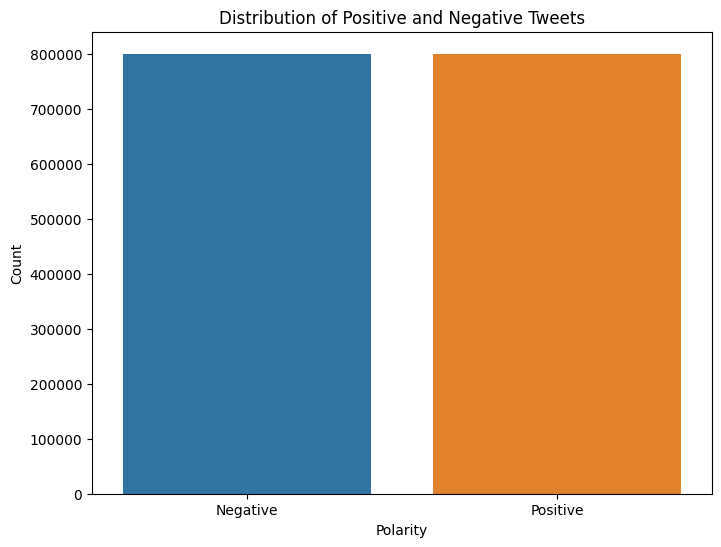

In [4]:
# Plotting the distribution of polarity
plt.figure(figsize=(8, 6))
sns.countplot(x='polarity', data=df)
plt.title('Distribution of Positive and Negative Tweets')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


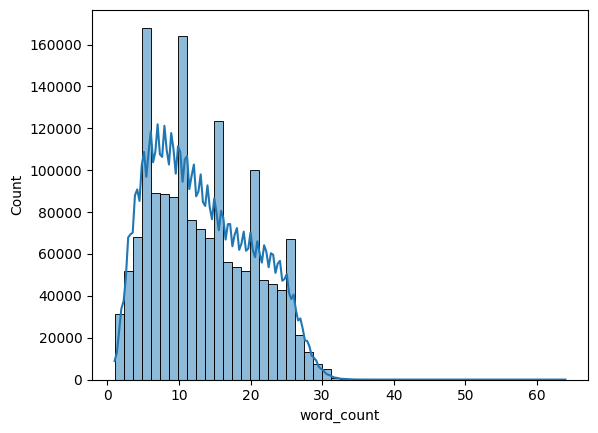

In [5]:
# Plotting the word count distribution
df['word_count'] = df['tweet'].apply(lambda x: len(x.split()))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.show()

#### Data Preprocessing

In [6]:
# Cleaning the tweets
def clean_tweet(tweet):
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet) # Removing @mentions
    tweet = re.sub(r'RT[\s]+', '', tweet) # Removing RT
    tweet = re.sub(r'https?:\/\/\S+', '', tweet) # Removing hyperlink
    tweet = re.sub(r'#', '', tweet) # Removing hashtag
    tweet = tweet.lower() # Converting to lower case
    tweet = re.sub(r'[^a-z]', ' ', tweet) # Removing non-alphabetic characters
    return tweet

# Applying the cleaning function to the tweets
df['tweet'] = df['tweet'].apply(clean_tweet)

In [15]:
# Splitting the data into train and test sets
df = df[['tweet','polarity']]

# Split the dataset into training and testing sets (80:20 ratio)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [16]:
# Define some hyperparameters
max_words = 10000 # The maximum number of words to keep in the vocabulary
max_len = 50 # The maximum length of a tweet in terms of words
embedding_dim = 100 # The dimension of the word embedding vectors
batch_size = 64 # The size of the mini-batches for training
epochs = 10 # The number of epochs for training

#### Embedding

In [17]:
# Create a tokenizer to convert the tweets into sequences of integers
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['tweet'])

# Convert the tweets into sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_data['tweet'])
test_sequences = tokenizer.texts_to_sequences(test_data['tweet'])

In [18]:
# Pad the sequences to have the same length
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# Convert the labels into numpy arrays
train_labels = np.array(train_data['polarity'])
test_labels = np.array(test_data['polarity'])

#### Model Selection & Architecture

In [19]:
# Load the pre-trained word embedding matrix from GloVe
# You can download the file from https://nlp.stanford.edu/projects/glove/
# We will use the 100-dimensional vectors trained on 6 billion tokens
embedding_index = {}
with open('/kaggle/input/pretrained/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Create an embedding matrix that matches the vocabulary of our tokenizer
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index < max_words:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[index] = vector

In [20]:
# Define the model architecture
# We will use a Bi-LSTM network with a pre-trained embedding layer, a dropout layer, and a dense layer
model = keras.Sequential([
  layers.Embedding(max_words, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False),
  layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
  layers.Bidirectional(layers.LSTM(64)),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')
])

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           1000000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 128)           84480     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1183425 (4.51 MB)
Trainable params: 1834

#### Model Training

In [21]:
# Split the training data into training and validation sets (80:20 ratio)
x_train, x_val, y_train, y_val = train_test_split(train_padded, train_labels, test_size=0.2, random_state=42)

# Train the model on the training set and validate on the validation set
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/10
16000/16000 [==============================] - 201s 12ms/step - loss: 0.4483 - accuracy: 0.7882 - val_loss: 0.4132 - val_accuracy: 0.8112
Epoch 2/10
16000/16000 [==============================] - 194s 12ms/step - loss: 0.4007 - accuracy: 0.8174 - val_loss: 0.3949 - val_accuracy: 0.8204
Epoch 3/10
16000/16000 [==============================] - 194s 12ms/step - loss: 0.3838 - accuracy: 0.8267 - val_loss: 0.3933 - val_accuracy: 0.8231
Epoch 4/10
16000/16000 [==============================] - 194s 12ms/step - loss: 0.3722 - accuracy: 0.8328 - val_loss: 0.3855 - val_accuracy: 0.8262
Epoch 5/10
16000/16000 [==============================] - 193s 12ms/step - loss: 0.3629 - accuracy: 0.8376 - val_loss: 0.3910 - val_accuracy: 0.8249
Epoch 6/10
16000/16000 [==============================] - 194s 12ms/step - loss: 0.3548 - accuracy: 0.8419 - val_loss: 0.3890 - val_accuracy: 0.8250
Epoch 7/10
16000/16000 [==============================] - 194s 12ms/step - loss: 0.3472 - accuracy: 0.8458

#### Evaluation

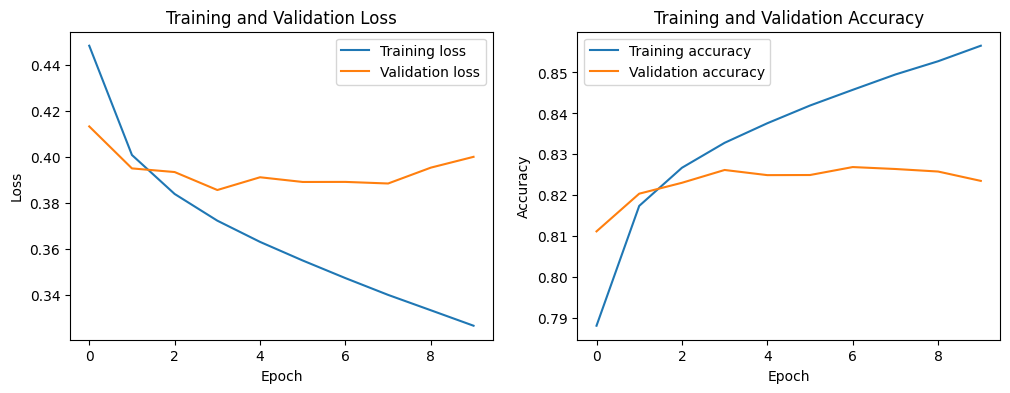

In [22]:
# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

In [23]:
# Evaluate the model on the testing set
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 58s 6ms/step - loss: 0.3978 - accuracy: 0.8236
Test loss: 0.3977501690387726
Test accuracy: 0.8236187696456909


#### Prediction and Classification Report

In [24]:
# Predict the polarity of the test data
test_predictions = model.predict(test_padded)
test_predictions = np.round(test_predictions).astype(int)

# Compute the classification report
cr = classification_report(test_labels, test_predictions, target_names=['negative', 'positive'])
print('Classification report:\n', cr)

10000/10000 [==============================] - 49s 5ms/step
Classification report:
               precision    recall  f1-score   support

    negative       0.82      0.82      0.82    159494
    positive       0.82      0.82      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



#### Confusion Matrix

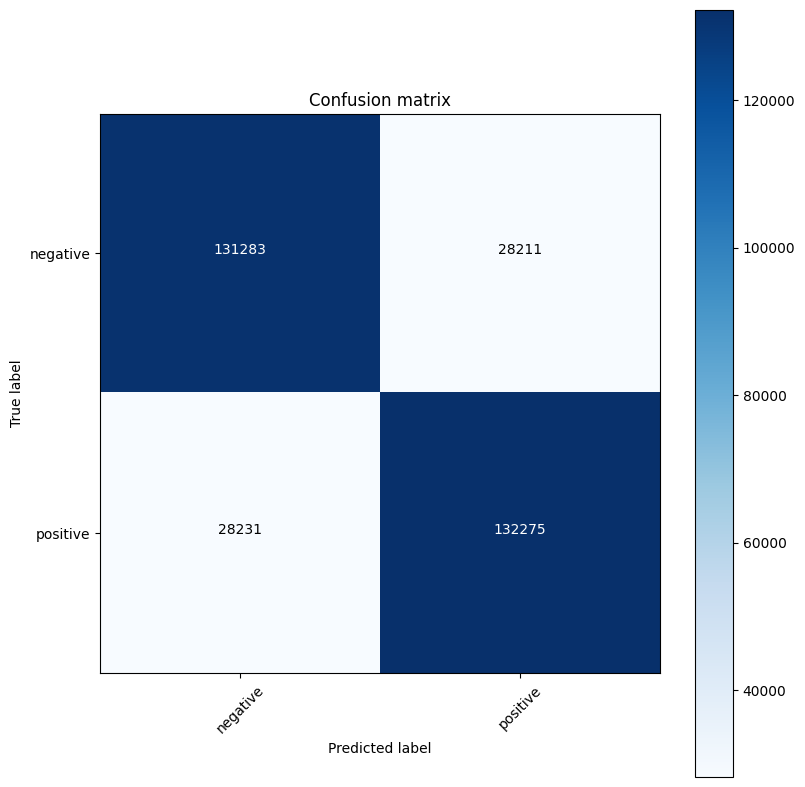

In [25]:
# Plot the confusion matrix using matplotlib
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['negative', 'positive'], rotation=45)
plt.yticks(tick_marks, ['negative', 'positive'])
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### Prediction of Sample Tweets

In [26]:
# Predict the polarity of some sample tweets
sample_tweets = [
  'I love this product. It is very useful and easy to use.',
  'This is the worst movie I have ever seen. The plot is boring and the acting is terrible.',
  'I am so happy today. I just got promoted and received a bonus.',
  'I hate this weather. It is so cold and rainy.',
  'This book is amazing. It is very well-written and engaging.'
]

# Convert the sample tweets into sequences of integers and pad them
sample_sequences = tokenizer.texts_to_sequences(sample_tweets)
sample_padded = pad_sequences(sample_sequences, maxlen=max_len, padding='post', truncating='post')

# Predict the polarity of the sample tweets
sample_predictions = model.predict(sample_padded)
sample_predictions = np.round(sample_predictions).astype(int)

# Print the sample tweets and their predicted polarity
for tweet, prediction in zip(sample_tweets, sample_predictions):
    print(tweet)
    print('Predicted polarity:', 'Positive' if prediction == 1 else 'Negative')
    print()

1/1 [==============================] - 1s 1s/step
I love this product. It is very useful and easy to use.
Predicted polarity: Positive

This is the worst movie I have ever seen. The plot is boring and the acting is terrible.
Predicted polarity: Negative

I am so happy today. I just got promoted and received a bonus.
Predicted polarity: Positive

I hate this weather. It is so cold and rainy.
Predicted polarity: Negative

This book is amazing. It is very well-written and engaging.
Predicted polarity: Positive



**Observations**
- The data has 1600000 tweets with equal number of positive and negative sentiments.
- The sentiment of tweets is almost evenly distributed between positive and negative, as depicted in the bar graph.
- The majority of tweets have less than 20 words, indicating that people tend to express their opinions concisely on Twitter. There is a sharp drop in the frequency of tweets after 10 words, suggesting that there is an optimal length for capturing attention and conveying sentiment on Twitter. The trend line shows a negative correlation between word count and tweet frequency, implying that longer tweets are less common and less popular on Twitter.
- The text is cleaned by removing the @, the URLs, the non-alphabetic characters, hyperlinks, extra whitespaces, etc. The text is tokenized and padded to a fixed length of 50 using the Tokenizer and pad_sequences functions from Keras.
- Defines hyperparameters like max_words, max_len, embedding_dim, batch_size, and epochs.
- Load the pretrained word embeddings from glove. Creates an embedding matrix based on the tokenizer's vocabulary.
- Chooses a Bidirectional LSTM model with a pre-trained embedding layer, a dropout layer, and a dense layer. Compile the model with binary crossentropy as loss and adam optimizer.
- The training data splits into training and validation sets and the fit the model.
- The model shows a good fit with low loss and high accuracy on the training set, but may be overfitting to the training data as the validation loss is not decreasing significantly and the validation accuracy is not increasing significantly after initial epochs.
- The classification report shows the performance metrics of the model on a test set of 320,000 tweets, with 50% of them being negative and 50% being positive. The metrics include precision, recall, f1-score, and accuracy for each class and the overall average.
- Precision is the ratio of true positives to the total number of predicted positives. Recall is the ratio of true positives to the total number of actual positives. F1-score is the harmonic mean of precision and recall. Accuracy is the ratio of correct predictions to the total number of predictions.
- The model has achieved an accuracy of 0.82, which means that it correctly classified 82% of the tweets. This is a good result, considering the complexity and variability of natural language data, especially on social media platforms like Twitter.
- The model has also achieved a balanced performance across both classes, with similar values of precision, recall, and f1-score for negative and positive sentiments. This indicates that the model is not biased towards any class and can handle both types of tweets equally well.
- The confusion matrix shows that the model has a high accuracy in classifying both positive and negative reviews. There are 131283 true negatives and 132275 true positives. However, there are also 28211 false positives and 28231 false negatives, indicating areas where the model can be improved.
- The model has a balanced precision and recall of 0.82 for both classes, meaning that it correctly identifies 82% of the positive and negative reviews, and also predicts 82% of the reviews as positive or negative correctly.
- The model has a low false positive rate of 0.18 for both classes, meaning that it wrongly predicts 18% of the negative reviews as positive, and 18% of the positive reviews as negative.
- The predictions on the new reviews are also correct, showing that the model can generalize well to unseen data.